In [82]:
# Import the libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt')
from collections import Counter
import re
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading BokehJS ...

In [84]:
consumerKey = "Ts7w6URgOYWXRfNuJwiUVoSz4"
consumerSecret = "iqItFdmQ84UtcMT7PDIx9Ygovjzd6PW4akEI27Q6MUmqIrbjaR"
accessToken = "1171293910175383554-17noADblkdWPPDVSYTXtyAIPsFsAqp"
accessTokenSecret = "MVUeVZQz0QkFbVcHTaKkusAZNK0RQf5qDvIlVjopYfL9G"

In [85]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret) 
    
# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret) 
    
# Creating the API object while passing in auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [86]:
from datetime import date

today = date.today()


In [87]:
data = pd.read_csv("Data.csv")

In [88]:
data.drop(data.columns[[3,4,5]], axis = 1, inplace = True) 

In [89]:
def findlat(city):
    latitude=data.Lat[data['City']==city]
    return latitude
def findlong(city):
    longitude=data.Long[data['City']==city]
    return longitude

In [90]:
def scraptweets(search_words,numTweets):
    max_range = 100
    for i in range(0, 1):
        tweets = tweepy.Cursor(api.search, lang="en",q=search_words, geocode="%f,%f,%dkm" % (latitude, longitude, max_range), tweet_mode='extended').items(numTweets)
        tweet_list = [tweet for tweet in tweets]
    for tweet in tweet_list:
        username = tweet.user.screen_name
        location = tweet.user.location
        hashtags = tweet.entities['hashtags']
        try:
            text = tweet.retweeted_status.full_text
        except:  # Not a Retweet
            text = tweet.full_text
            ith_tweet = [username, location, text, hashtags]
            db_tweets.loc[len(db_tweets)] = ith_tweet

In [91]:
# Initialise these variables:
db_tweets = pd.DataFrame(columns = ['username','location', 'text', 'hashtags'])
search_words = "women"
date_since = today
city=input("Enter your city: ")
latitude= findlat(city)
longitude = findlong(city)
scraptweets(search_words,100)

Enter your city: Delhi


# Data cleaning

In [92]:
dataset=db_tweets

In [93]:
dataset.shape

(6, 4)

### Cleaning for duplicates and null values

In [94]:
dataset['text'].isna().sum() #no null tweets

0

### Removing mentions

In [95]:
dataset['clean_tweet'] = dataset['text'].apply(lambda x: ' '.join([tweet for tweet in x.split() if not tweet.startswith("@")]))

In [96]:
dataset.head()

,username,location,text,hashtags,clean_tweet
0,nickhunterr,"New Delhi, India",@Paprikaashh @MiishNottyAna women are fake .,[],women are fake .
1,gaydelhi,Delhi,Confessions of a midlife bride - and what make...,[],Confessions of a midlife bride - and what make...
2,arpitabanerjee1,"New Delhi, India",Listening to HBR's Women at Work podcast right...,"[{'text': 'WorkingWomen', 'indices': [83, 96]}]",Listening to HBR's Women at Work podcast right...
3,Sushmit80792882,"New Delhi, India",@a_network_slice @HinduB0T @ahindu_ Women are ...,[],Women are not needed in defence. They arent ph...
4,DeepikaBhardwaj,"Gurgaon, India",No women's commission or women's rights activi...,"[{'text': 'falserape', 'indices': [169, 179]},...",No women's commission or women's rights activi...


### Removing numbers

In [97]:
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: ' '.join([tweet for tweet in x.split() if not tweet.isnumeric()]))

### Correcting slang words

In [98]:
slang = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
          'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother', 'cud':'could',
         'fud':'food', 'u':'you', 'ur':'your', 'frm': 'from'}

dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join(slang[word] if word in slang else word for word in x.split()))

### Finding hashtags

In [99]:
dataset['Hashtags'] = dataset['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))

In [100]:
dataset.drop('text',axis=1,inplace=True)
dataset.drop('hashtags',axis=1,inplace=True)
dataset.head()

,username,location,clean_tweet,Hashtags
0,nickhunterr,"New Delhi, India",women are fake .,
1,gaydelhi,Delhi,Confessions of a midlife bride - and what make...,
2,arpitabanerjee1,"New Delhi, India",Listening to HBR's Women at Work podcast right...,#WorkingWomen
3,Sushmit80792882,"New Delhi, India",Women are not needed in defence. They arent ph...,
4,DeepikaBhardwaj,"Gurgaon, India",No women's commission or women's rights activi...,#falserape #IndiasSons


### Removing stopwords

In [101]:
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))

### Lemmatization

In [102]:
lemmatizer = WordNetLemmatizer()
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


### Stemming

In [103]:
ps = PorterStemmer()
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

In [104]:
#dataset.drop('hashtags',axis=1,inplace=True)
dataset['text']=dataset['clean_tweet']
dataset.drop('clean_tweet',axis=1,inplace=True)

# Visualizations

### Wordcloud

In [105]:
df = dataset

In [106]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['text'].apply(getSubjectivity)
df['Polarity'] = df['text'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'


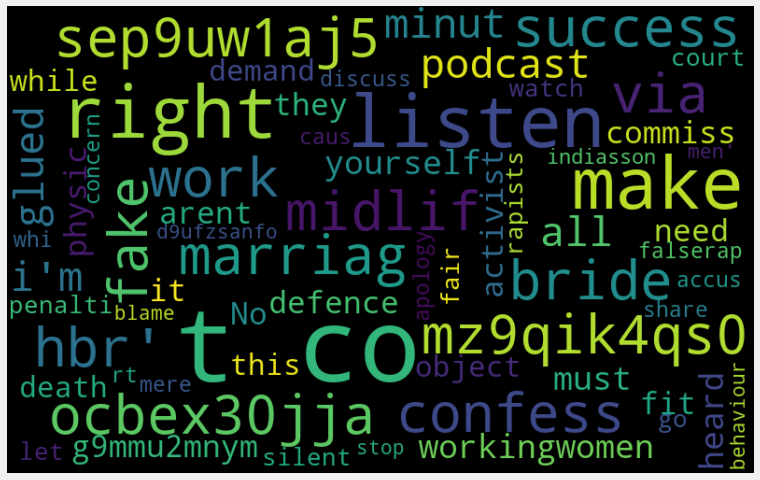

In [107]:
allWords = ' '.join([twts for twts in df['text']])
new_stopwords=["woman","women","girl","women'","https"]
wc = WordCloud(width = 800, height = 500, max_font_size = 110, max_words=100, stopwords=new_stopwords).generate(allWords)
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [108]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['Analysis'] = df['Polarity'].apply(getAnalysis)
# Show the dataframe
df

,username,location,Hashtags,text,Subjectivity,Polarity,Analysis
0,nickhunterr,"New Delhi, India",,woman fake .,1.000000,-0.500000,Negative
1,gaydelhi,Delhi,,confess midlif bride - make marriag success - ...,0.000000,0.300000,Positive
2,arpitabanerjee1,"New Delhi, India",#WorkingWomen,listen hbr' women work podcast right minut i'm...,0.535714,0.446429,Positive
3,Sushmit80792882,"New Delhi, India",,women need defence. they arent physic fit it.,0.400000,0.400000,Positive
4,DeepikaBhardwaj,"Gurgaon, India",#falserape #IndiasSons,No women' commiss women' right activist object...,0.508929,0.121429,Positive
5,elixirofnothing,"New Delhi, India",,stop blame woman men' behaviour,0.000000,0.000000,Neutral


In [109]:
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['text']
ptweets

round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)

66.7

In [110]:
ptweets

1    confess midlif bride - make marriag success - ...
2    listen hbr' women work podcast right minut i'm...
3        women need defence. they arent physic fit it.
4    No women' commiss women' right activist object...
Name: text, dtype: object

In [111]:
ntweets = df[df.Analysis == 'Negative']
ntext = ntweets['text']
nusers = ntweets['username']
data = nusers.head(10)
print(data)
#ntweets

#round( (ntweets.shape[0] / df.shape[0]) * 100, 1)

0    nickhunterr
Name: username, dtype: object


In [112]:
df['Analysis'].value_counts()

Positive    4
Negative    1
Neutral     1
Name: Analysis, dtype: int64

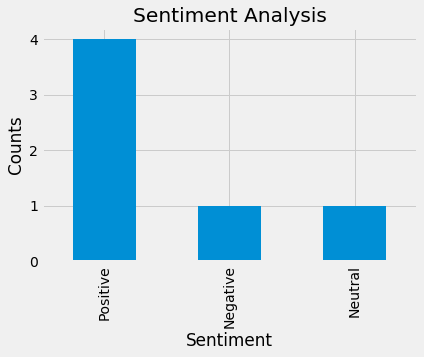

In [113]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

In [114]:
nusers

0    nickhunterr
Name: username, dtype: object